# Rice Classification: Classifying a Grain of Rice with Neutral Physical Properties
### DSCI100: Project Proposal (Group 124)

##### Sean Park (66350992)
##### Deacon Sowerby (50471499)
##### Gabriel Reyes (80274921)
##### David Rao (55832919)

In [1]:
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows=10)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

## 1. Introduction

### -> About the dataset
Different types of rice are classified biologically by their origin; however, some of these types can also be identified by their physical shape. In our dataset, "riceClassification.csv", there are more than 18,000 observations of rice grains with specified physical measurements that classify as either the rice type "**Gonen**' (indicated by the factor 0) or "**Jasmine**" (indicated by the factor 1). This data has been specially modified for binary classification.

In [2]:
url = "https://raw.githubusercontent.com/sean-prk/dsci-group-project-report/main/riceClassification.csv"
# referenced a csv file from our own GitHub repository

download.file(url, "riceClassification.csv")

# we tidied the data here to be able to explain our objective more clearly
rice_data <- read_csv("riceClassification.csv") |>
    mutate(Class = as_factor(Class)) |>
    select(id:Class)
rice_data

New names:
• `` -> `...1`
Rows: 18186 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (13): ...1, id, Area, MajorAxisLength, MinorAxisLength, Eccentricity, Co...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,4537,92.22932,64.01277,0.7199162,4677,76.00452,0.6575362,273.085,0.7645096,1.440796,1
2,2872,74.69188,51.40045,0.7255527,3015,60.47102,0.7130089,208.317,0.8316582,1.453137,1
3,3048,76.29316,52.04349,0.7312109,3132,62.29634,0.7591532,210.012,0.8684336,1.465950,1
4,3073,77.03363,51.92849,0.7386387,3157,62.55130,0.7835288,210.657,0.8702031,1.483456,1
5,3693,85.12478,56.37402,0.7492816,3802,68.57167,0.7693750,230.332,0.8747433,1.510000,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
18182,5853,148.6246,51.02928,0.9392099,6008,86.32654,0.4985944,332.960,0.6634440,2.912535,0
18183,7585,169.5940,58.14166,0.9393980,7806,98.27269,0.6474605,385.506,0.6413619,2.916910,0
18184,6365,154.7771,52.90808,0.9397603,6531,90.02316,0.5612875,342.253,0.6828318,2.925396,0


### -> Our objective

Consider this specific rice observation in our dataset (id=9056), which we will store in the variable "test_obs". Despite it being classified as Jasmine (1), we noticed that the measurements for this observation seems fairly neutral between the two classes; in other words, it is difficult to predict the class of this observation with confidence, as its measurements are not too swayed in favour of either class (see plots displayed under "visualizations" below).

In [1]:
test_obs <- rice_data |>
    slice(9056)
test_obs

ERROR: Error in slice(rice_data, 9056): could not find function "slice"


We will build a classifier that classifies a rice grain as either Gonen or Jasmine given its physical properties. Using this classifier, we want to predict the class of this test_obs, and check if our classifier will be able to accurately determine its real class, despite its seemingly neutral properties.

### -> Our question
**Which class, either Gonen or Jasmine, will this seemingly neutral observation be classified as?**
Does it match its real class? Is the prediction accurate enough to trust our answer?

### -> Our thesis

We expect our test observation to be classified as its true class, **"Jasmine" (1)**. Since the measurement distribution between the two classes in this dataset are visibly distinct (as the dataset was intended for binary classification) and because there are thousands of observations for our classifier to reference, our classifier will most likely have a high accuracy. Therefore, although the measurements are seemingly neutral, there is a greater chance that this observation will be correctly classified.

## 2. Methods and Results

### -> Pre-analysis

Note that we have already loaded in and tidied our dataset (in the variable "rice_data", and we have pulled the observation that we wish to test for our result (in the variable "test_obs").

### -> Summary by class

Below is the mean value for all variables in the dataset, summarized by each class. An observation count for each class is also added.

In [4]:
rice_summary <- rice_data |>
    group_by(Class) |>
    summarize(Count = n(), across(c(Area:AspectRation), ~ mean(.x, na.rm = TRUE)))
rice_summary

Class,Count,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,8200,8358.541,153.6984,69.99743,0.8887991,8575.295,102.98017,0.6516059,368.9664,0.7697762,2.199598
1,9986,5950.893,150.0239,51.44068,0.9372549,6117.695,86.86806,0.5879511,337.3522,0.6572694,2.927116


We see that there are slightly more rice observations that classify as Jasmine (1) than Gonen (0), and we are also able to identify the distinctions by variable values between the two classes.

### -> Visualiations

The following plots demonstrate each class' distribution of values within each variable. We paired the variables in a scatterplot to recognize any significant relationships that may occur. The highlighted point in each plot represents the "neutral" observation (test_obs) that we will be predicting for our project. Note that **0=Gonen, and 1=Jasmine**.

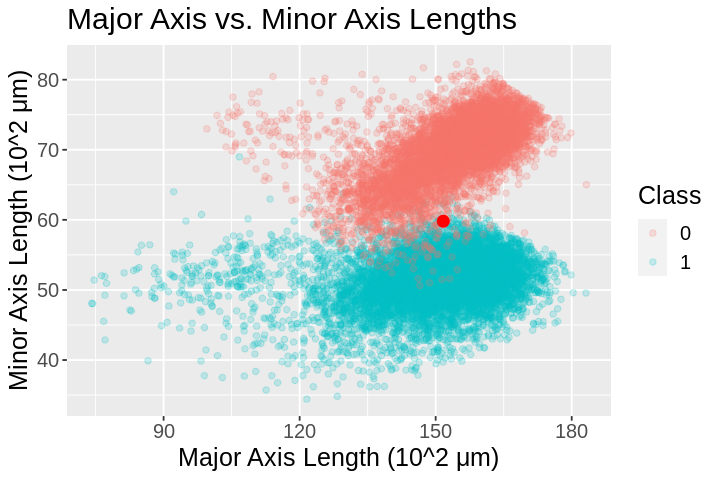

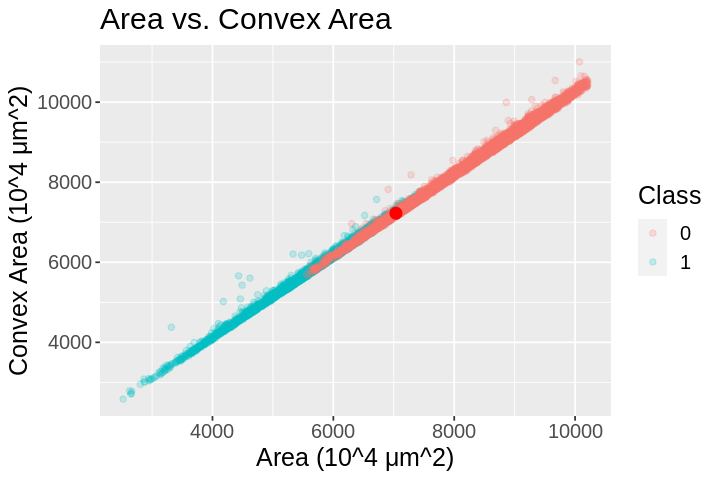

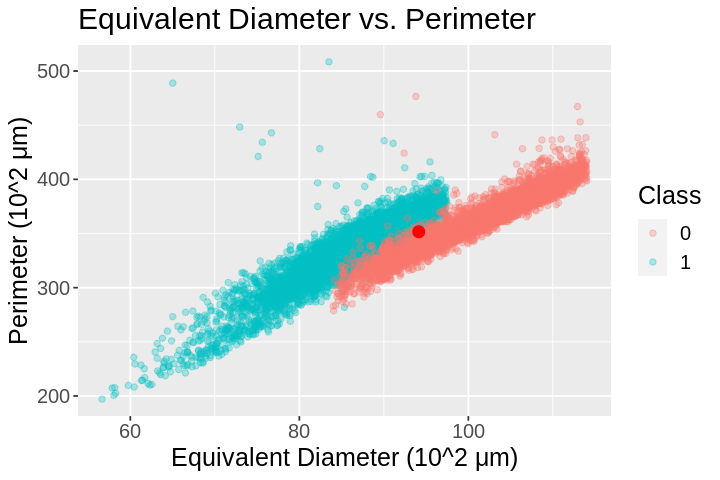

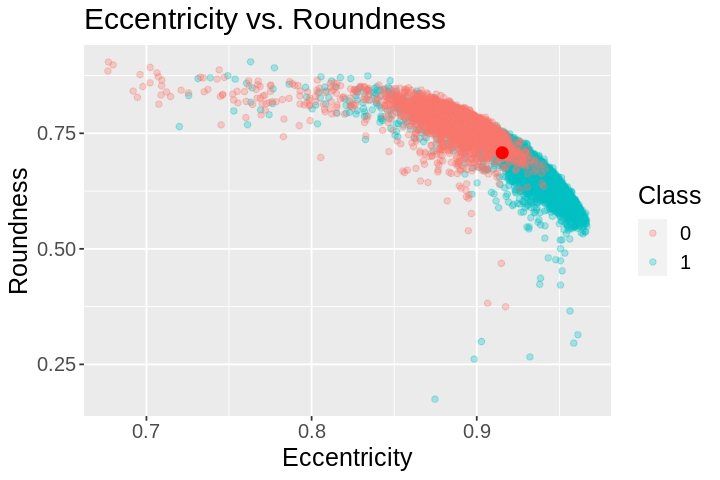

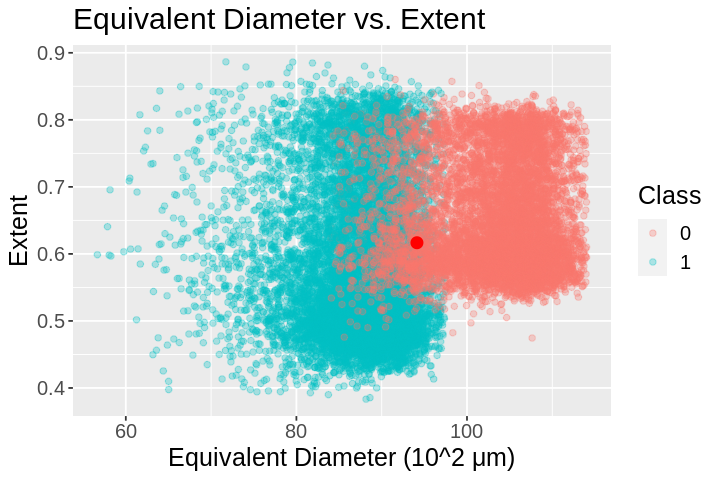

In [5]:
options(repr.plot.width=6,repr.plot.height=4)
#MajorAxisLength vs MinorAxisLength
ggplot(rice_data, aes(x=MajorAxisLength, y = MinorAxisLength, color=Class)) +
    geom_point(alpha=0.2) + 
    ggtitle("Major Axis vs. Minor Axis Lengths")  +
    labs(x = "Major Axis Length (10^2 μm)",
         y = "Minor Axis Length (10^2 μm)") +
    geom_point(data=test_obs,
             aes(x=MajorAxisLength,y=MinorAxisLength), 
             color='red',
             size=3) +
    theme(text = element_text(size=15))

#Area vs ConvexArea
ggplot(rice_data, aes(x=Area, y = ConvexArea, color=Class)) +
    geom_point(alpha=0.2) + 
    ggtitle("Area vs. Convex Area")  +
    labs(x = "Area (10^4 μm^2)",
         y = "Convex Area (10^4 μm^2)") +
    geom_point(data=test_obs,
             aes(x=Area,y=ConvexArea), 
             color='red',
             size=3) +
    theme(text = element_text(size=15))

#EquivDiameter vs Perimeter
ggplot(rice_data, aes(x=EquivDiameter, y = Perimeter, color=Class)) +
    geom_point(alpha=0.3) + 
    ggtitle("Equivalent Diameter vs. Perimeter")  +
    labs(x = "Equivalent Diameter (10^2 μm)",
         y = "Perimeter (10^2 μm)") +
    geom_point(data=test_obs,
             aes(x=EquivDiameter,y=Perimeter), 
             color='red',
             size=3) +
    theme(text = element_text(size=15))

#Eccentricity vs Roundness
ggplot(rice_data, aes(x=Eccentricity, y = Roundness, color=Class)) +
    geom_point(alpha=0.3) + 
    ggtitle("Eccentricity vs. Roundness")  +
    labs(x = "Eccentricity",
         y = "Roundness") +
    geom_point(data=test_obs,
             aes(x=Eccentricity,y=Roundness), 
             color='red',
             size=3) +
    theme(text = element_text(size=15))

#EquivDiameter vs Extent
ggplot(rice_data, aes(x=EquivDiameter, y = Extent, color=Class)) +
    geom_point(alpha=0.3) + 
    ggtitle("Equivalent Diameter vs. Extent")  +
    labs(x = "Equivalent Diameter (10^2 μm)",
         y = "Extent") +
    geom_point(data=test_obs,
             aes(x=EquivDiameter,y=Extent), 
             color='red',
             size=3) +
    theme(text = element_text(size=15))

### -> Selecting predictors

We will omit the following predictors from our classifier model:

* **id**: The unique identifier for each observation
* **ConvexArea**: Has a strong positive relationship with Area. Since we can accurately estimate ConvexArea using Area, there is no need to keep both variables in the dataset.
* **AspectRation**: Is calculated by dividing length by width, which is unneeded if we have MajorAxisLength and MinorAxisLength.
* **Roundness**: Feature is similar to Eccentricity (both represent the deviation from the curve)

This leaves us with seven predictors. However, we are also uncertain of the effectivenes of the two predictors below:

* **MajorAxisLength**: No distinct distribution between two classes, therefore may not be useful for effective classification (see first plot above).
* **Extent**: Like MajorAxisLength, the distribution of values is not very distinct for each class (see last plot above).

Therefore, to test the usefulness of these two predictors, during our analysis, we will create four separate models as follows:

    * other predictors + none
    * other predictors + MajorAxisLength
    * other predictors + Extent
    * other predictors + MajorAxisLength + Extent
    
... and choose the model that gives the highest accuracy.

### -> Data analysis with steps

##### i) Splitting the data

We first split our data into training and testing data, with 75% of our data going to the training set.

In [6]:
set.seed(5431)

rice_split <- initial_split(rice_data, prop = 3/4, strata = Class)  
rice_train <- training(rice_split)   
rice_test <- testing(rice_split)
#rice_train
#rice_test

In [7]:
#Confirm our observation in question is in testing set.
filter(rice_test, id == 9056)

id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
9056,7036,151.6808,59.80785,0.9154064,7225,94.13249,0.6166529,351.607,0.7079983,2.599081,1


##### ii) Creating a tuning model and setting up for cross validation

In [8]:
set.seed(5432)

#Standard tuning model for KNN classification
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
       set_engine("kknn") |>
       set_mode("classification")

#Spliting training data up for 10-fold cross validation.
rice_vfold <- vfold_cv(rice_train, v = 5, strata = Class)

##### iii) Creating the recipes

As mentioned in the predictor selection step, we will create 4 recipes, each with their own predictor combination.

In [9]:
#Recipe with predictors + MajorAxisLength
recipe_1 <- recipe(Class ~ MinorAxisLength + Eccentricity + EquivDiameter + Perimeter + MajorAxisLength,
                   data = rice_train) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

#Recipe with predictors + Extent
recipe_2 <- recipe(Class ~ MinorAxisLength + Eccentricity + EquivDiameter + Perimeter + Extent,
                   data = rice_train)|>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

#Recipe with predictors + MajorAxisLength + Extent
recipe_3 <- recipe(Class ~ MinorAxisLength + Eccentricity + EquivDiameter + Perimeter + MajorAxisLength + Extent,
                   data = rice_train)|>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

#Recipe with predictors only
recipe_4 <- recipe(Class ~ MinorAxisLength + Eccentricity + EquivDiameter + Perimeter,
                   data = rice_train)|>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

##### iii) Tuning the model and choosing the best K for each recipe

For each recipe, we will find the best accuracy by tuning for K values from a range of [2,50].

In [10]:
# List of K values

k_vals <- tibble(neighbors = seq(from=1,to=10,by=1)) 
# since we have thousands of observations, we might want a higher k parameter.

In [11]:
# ACCURACY TEST FOR RECIPE_1

set.seed(5432)

k_accuracy_1 <- workflow() |>
       
    # we tune for the best K on recipe 1
       add_recipe(recipe_1) |>
       add_model(knn_tune) |>
       tune_grid(resamples = rice_vfold, grid = k_vals) |>
       collect_metrics() |>

    # filter the result and find the parameter k with the highest accuracy

       filter(.metric == "accuracy") |>
       arrange(desc(mean)) |>
       slice(1) |>     # collects the highest k parameter as well as the accuracy it gives
                       # (for this specific choice of predictors)
       select(neighbors, mean)

k_accuracy_1

neighbors,mean
<dbl>,<dbl>
5,0.9890753


In [13]:
# ACCURACY TEST FOR RECIPE_2

set.seed(5432)

# Repeating the process of the first recipe:

k_accuracy_2 <- workflow() |>
       
    # we tune for the best K on recipe 2
       add_recipe(recipe_2) |>
       add_model(knn_tune) |>
       tune_grid(resamples = rice_vfold, grid = k_vals) |>
       collect_metrics() |>

    # filter the result and find the parameter k with the highest accuracy

       filter(.metric == "accuracy") |>
       arrange(desc(mean)) |>
       slice(1) |>
       select(neighbors, mean)

k_accuracy_2

neighbors,mean
<dbl>,<dbl>
7,0.9880488


In [15]:
# ACCURACY TEST FOR RECIPE_3

set.seed(5432)

k_accuracy_3 <- workflow() |>
       
    # we tune for the best K on recipe 3
       add_recipe(recipe_3) |>
       add_model(knn_tune) |>
       tune_grid(resamples = rice_vfold, grid = k_vals) |>
       collect_metrics() |>

    # filter the result and find the parameter k with the highest accuracy

       filter(.metric == "accuracy") |>
       arrange(desc(mean)) |>
       slice(1) |>
       select(neighbors, mean)

k_accuracy_3

neighbors,mean
<dbl>,<dbl>
7,0.9886354


In [16]:
# ACCURACY TEST FOR RECIPE_4

set.seed(5432)

k_accuracy_4 <- workflow() |>
       
    # we tune for the best K on recipe 4
       add_recipe(recipe_4) |>
       add_model(knn_tune) |>
       tune_grid(resamples = rice_vfold, grid = k_vals) |>
       collect_metrics() |>

    # filter the result and find the parameter k with the highest accuracy

       filter(.metric == "accuracy") |>
       arrange(desc(mean)) |>
       slice(1) |>
       select(neighbors, mean)

k_accuracy_4

neighbors,mean
<dbl>,<dbl>
7,0.9887821


##### iv) Making a model with the best recipe, using the best parameter K

We see that the best predictor combination is in recipe 1 (only including our confirmed predictors + MajorAxisLength) as it has the best trade off, yielding the highest accuracy and the lowest number of neighbours. Using this information, we create a final workflow model with the best recipe and KNN model with the corresponding K value.

In [18]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |> 
       set_engine("kknn") |>                    #best k value for the recipe we have chosen (see above)
       set_mode("classification")

# we fit the final model in a workflow model and finalize our classifier.
rice_fit <- workflow() |>
       add_recipe(recipe_1) |>
       add_model(knn_spec) |>
       fit(data = rice_train)

##### v) Evaluating the estimated accuracy of the classifier

We determine the accuracy of our final classifier by finding the accuracy of our classifier on our training set.

In [19]:
rice_test_predictions <- predict(rice_fit , rice_test) |>
       bind_cols(rice_test)
#rice_test_predictions

rice_prediction_accuracy <- rice_test_predictions |>
         metrics(truth = Class, estimate = .pred_class)             

rice_prediction_accuracy # <- this seems oddly high

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9896635
kap,binary,0.9791116


##### vi) Classifying test_obs

Finally, we get the observation we pulled initially (the one with fairly neutral measurements), and see if the classifier predicts correctly. (Recall the real class for the observation is **Jasmine (1)**.

In [20]:
rice_neutral_prediction <- predict(rice_fit , test_obs)
rice_neutral_prediction

.pred_class
<fct>
1


## 3.  Discussion

... what we found, if it matches our thesis, statistical impact of findings, possible future questions.

REMEMBER TO USE REFERENCES, AND SEND THEM TO ME (SEAN)

Include:
- our data was intended for binary classification, so results could be more ideal
- the execution of the program took too long due to the large number of predictors, observations, and k values being tested. We could improve this in the future by...

## 4. References

